### Problem Statement
Crime analysis is a law enforcement duty that involves a systematic investigation of patterns and trends in crime and disorder. Pattern information can help law enforcement organizations deploy resources more effectively and aid detectives in locating and apprehending criminals. Crime analysis is also important in developing answers to crime problems and developing crime prevention methods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.express as ex
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Plot Settings
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
plt.style.use('seaborn-darkgrid')
sns.set_palette("bright")

C:\Users\Sahil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
from f

In [2]:
# loading data
df = pd.read_csv('Legacy_Baton_Rouge_Crime_Incidents - Copy.csv',low_memory=False)
df.head()

,FILE NUMBER,OFFENSE DATE,date,OFFENSE TIME,Time1,Time,CRIME,COMMITTED,OFFENSE,OFFENSE DESCRIPTION,...,CITY,STATE,ZIP CODE,DISTRICT,ZONE,SUBZONE,COMPLETE DISTRICT,COUNCIL DISTRICT,CRIME PREVENTION DISTRICT,GEOLOCATION
0,NaN,04-11-2020,04-11-2020,1645,1645,16:45,SEXUAL ASSAULT,COMMITTED,14:43.1,BATT/SEXUAL,...,NaN,NaN,70802.0,2,C,1,2C1,10.0,NONE,NaN
1,NaN,10/28/2019,10-28-2019,2248,2248,22:48,JUVENILE,COMMITTED,0.639583333,IND BEHAVIOR W/JUV,...,NaN,NaN,70807.0,4,B,3,4B3,2.0,NONE,NaN
2,NaN,11-05-2019,11-05-2019,537,0537,05:37,SEXUAL ASSAULT,COMMITTED,14:43.1,BATT/SEXUAL,...,NaN,NaN,70802.0,1,A,1,1A1,10.0,NONE,NaN
3,NaN,11-09-2019,11-09-2019,2345,2345,23:45,SEXUAL ASSAULT,ATTEMPTED,14:42.1/B,RAPE/ATT FORCIBLE,...,NaN,NaN,70816.0,3,E,5,3.00E+05,8.0,NONE,NaN
4,NaN,03/14/2020,03-14-2020,1657,1657,16:57,JUVENILE,COMMITTED,0.639583333,IND BEHAVIOR W/JUV,...,NaN,NaN,70805.0,NaN,NaN,NaN,NaN,7.0,NONE,NaN


In [7]:
# Getting the shape of the dataset
df.shape

(490578, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490578 entries, 0 to 490577
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 490578 non-null  object 
 1   Time                 490578 non-null  object 
 2   CRIME                490578 non-null  object 
 3   COMMITTED            490578 non-null  object 
 4   OFFENSE              490578 non-null  object 
 5   OFFENSE DESCRIPTION  490578 non-null  object 
 6   ADDRESS NUMBER       482448 non-null  float64
 7   STREET NAME          483265 non-null  object 
 8   STREET TYPE          466665 non-null  object 
 9   ZIP CODE             487531 non-null  float64
 10  DISTRICT             467456 non-null  object 
 11  ZONE                 467456 non-null  object 
 12  SUBZONE              467456 non-null  object 
 13  COMPLETE DISTRICT    467456 non-null  object 
 14  COUNCIL DISTRICT     487263 non-null  float64
dtypes: float64(3), ob

In [8]:
# let's see what is the percentage of missing values in each column
df.isna().mean()*100

FILE NUMBER                   1.490691
OFFENSE DATE                  0.000000
date                          0.000000
OFFENSE TIME                  0.000000
Time1                         0.000000
Time                          0.000000
CRIME                         0.000000
COMMITTED                     0.000000
OFFENSE                       0.000000
OFFENSE DESCRIPTION           0.000000
FULL ADDRESS                  1.490691
ADDRESS NUMBER                1.657229
STREET DIRECTION             83.642968
STREET NAME                   1.490691
STREET TYPE                   4.874454
CITY                          1.490691
STATE                         1.490691
ZIP CODE                      0.621104
DISTRICT                      4.713216
ZONE                          4.713216
SUBZONE                       4.713216
COMPLETE DISTRICT             4.713216
COUNCIL DISTRICT              0.675734
CRIME PREVENTION DISTRICT     0.673695
GEOLOCATION                   1.490691
dtype: float64

#### Observation
* Column Street Direction contains the highest number of missing values, which is 83%. So won't be able to use this column for our analysis, so we will drop it.
* The remaining columns contains between 0.67% to 4.7% of missing values, which is not problematic.

In [9]:
# Percentage of missing values in dataset.
df.isna().mean().mean()*100

4.7976876256171295

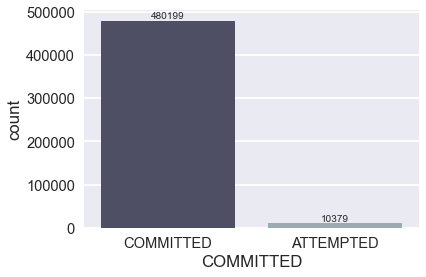

In [10]:
# let's see our target variable
ax = sns.countplot(x=df['COMMITTED'],palette='bone')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

#### Observations:

* The number of crimes committed by citizens is extremly high as compared to the number of attempts that were made.

### Removing unuseful columns

In [11]:
df.head()

,FILE NUMBER,OFFENSE DATE,date,OFFENSE TIME,Time1,Time,CRIME,COMMITTED,OFFENSE,OFFENSE DESCRIPTION,...,CITY,STATE,ZIP CODE,DISTRICT,ZONE,SUBZONE,COMPLETE DISTRICT,COUNCIL DISTRICT,CRIME PREVENTION DISTRICT,GEOLOCATION
0,NaN,04-11-2020,04-11-2020,1645,1645,16:45,SEXUAL ASSAULT,COMMITTED,14:43.1,BATT/SEXUAL,...,NaN,NaN,70802.0,2,C,1,2C1,10.0,NONE,NaN
1,NaN,10/28/2019,10-28-2019,2248,2248,22:48,JUVENILE,COMMITTED,0.639583333,IND BEHAVIOR W/JUV,...,NaN,NaN,70807.0,4,B,3,4B3,2.0,NONE,NaN
2,NaN,11-05-2019,11-05-2019,537,0537,05:37,SEXUAL ASSAULT,COMMITTED,14:43.1,BATT/SEXUAL,...,NaN,NaN,70802.0,1,A,1,1A1,10.0,NONE,NaN
3,NaN,11-09-2019,11-09-2019,2345,2345,23:45,SEXUAL ASSAULT,ATTEMPTED,14:42.1/B,RAPE/ATT FORCIBLE,...,NaN,NaN,70816.0,3,E,5,3.00E+05,8.0,NONE,NaN
4,NaN,03/14/2020,03-14-2020,1657,1657,16:57,JUVENILE,COMMITTED,0.639583333,IND BEHAVIOR W/JUV,...,NaN,NaN,70805.0,NaN,NaN,NaN,NaN,7.0,NONE,NaN


In [3]:
df.drop(['FILE NUMBER','OFFENSE DATE','Time1','OFFENSE TIME','FULL ADDRESS','GEOLOCATION','STREET DIRECTION','CITY','STATE','CRIME PREVENTION DISTRICT'],axis=1,inplace=True)

#### How I was able to come up with column names, that should be removed?
* I examined each column separately, and was able to figure out that which one could be useful while analysis. I am doing all of this to reduce the size of the dataset to make it process faster while analysis.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490578 entries, 0 to 490577
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 490578 non-null  object 
 1   Time                 490578 non-null  object 
 2   CRIME                490578 non-null  object 
 3   COMMITTED            490578 non-null  object 
 4   OFFENSE              490578 non-null  object 
 5   OFFENSE DESCRIPTION  490578 non-null  object 
 6   ADDRESS NUMBER       482448 non-null  float64
 7   STREET NAME          483265 non-null  object 
 8   STREET TYPE          466665 non-null  object 
 9   ZIP CODE             487531 non-null  float64
 10  DISTRICT             467456 non-null  object 
 11  ZONE                 467456 non-null  object 
 12  SUBZONE              467456 non-null  object 
 13  COMPLETE DISTRICT    467456 non-null  object 
 14  COUNCIL DISTRICT     487263 non-null  float64
dtypes: float64(3), ob

In [99]:
dfc = df.dropna()
dfc.shape[0] - df.shape[0]

-48278

In [103]:
dfc.isna().sum().sum()

0

### EDA

#### 1. What are the most common Crimes?

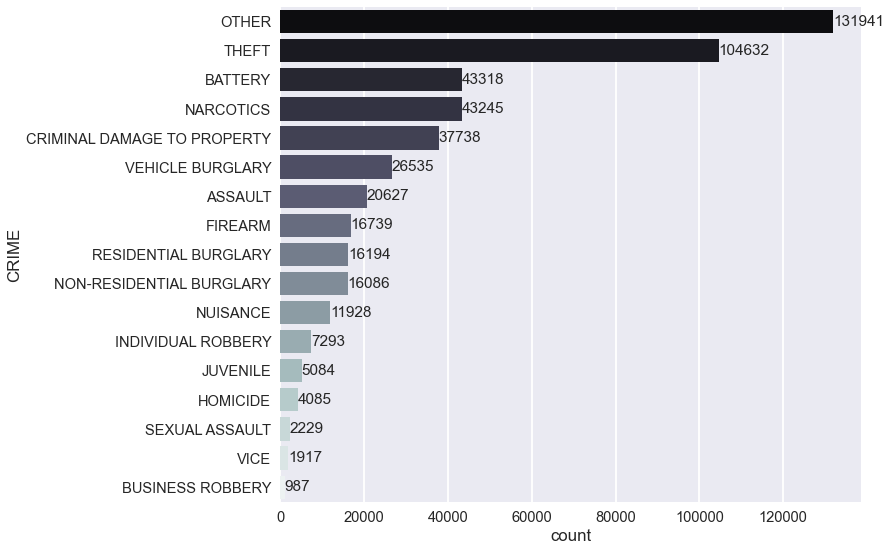

In [9]:
sort_order = df.groupby('CRIME')['CRIME'].agg('count').sort_values(ascending=False)
ax = sns.countplot(y=df['CRIME'],order=sort_order.index,palette='bone')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

#### Observations:

* Theft is the most common crime among criminals. However, we can't say that other constitutes the largest crime rate simply, because it could include other criminal activities.
*  Business Robbery was at the least position with 967 number of crimes.

#### 2. What are the top 10 and bottom 10 offenses (offense description)?

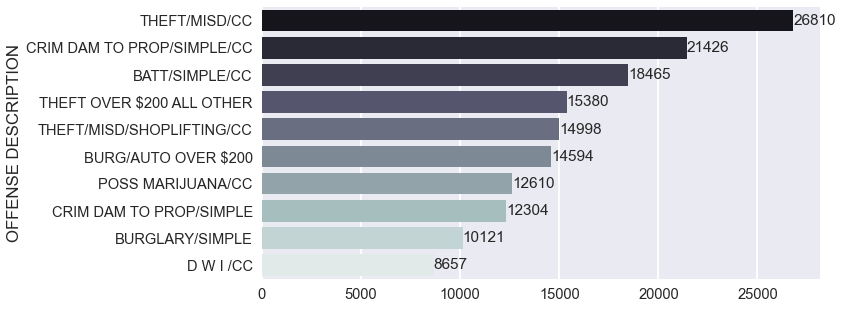

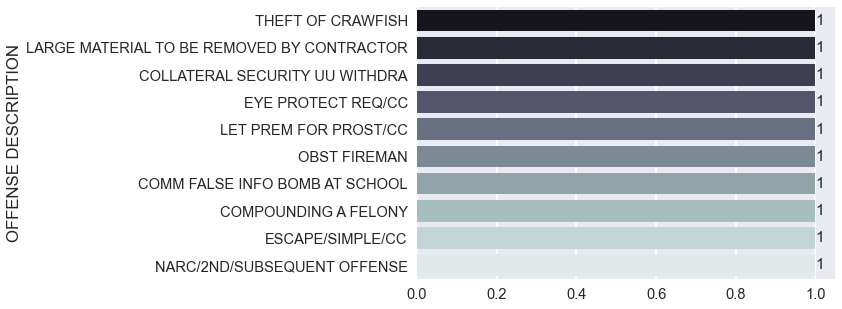

In [10]:
top_10 = df.groupby('OFFENSE DESCRIPTION')['OFFENSE DESCRIPTION'].agg('count').sort_values(ascending=False)[:10]

plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_10.values, y=top_10.index,palette="bone")
for i in ax.containers:
    plt.bar_label(i)


bottom_10 = df.groupby('OFFENSE DESCRIPTION')['OFFENSE DESCRIPTION'].agg('count').sort_values(ascending=False)[-10:]
plt.figure(figsize=(7.5,5))
ax = sns.barplot(x=bottom_10.values, y=bottom_10.index,palette="bone")
for i in ax.containers:
    plt.bar_label(i)

    
plt.show()

#### Observation:
1. THEFT/MISD/CC holds the highest number of crimes, which is approximately 26K, while the NARC/2ND had the least number of crimes.

#### What are the top 20 Offense sections/articles that were voilated?

(0.0, 100.0, 0.0, 100.0)

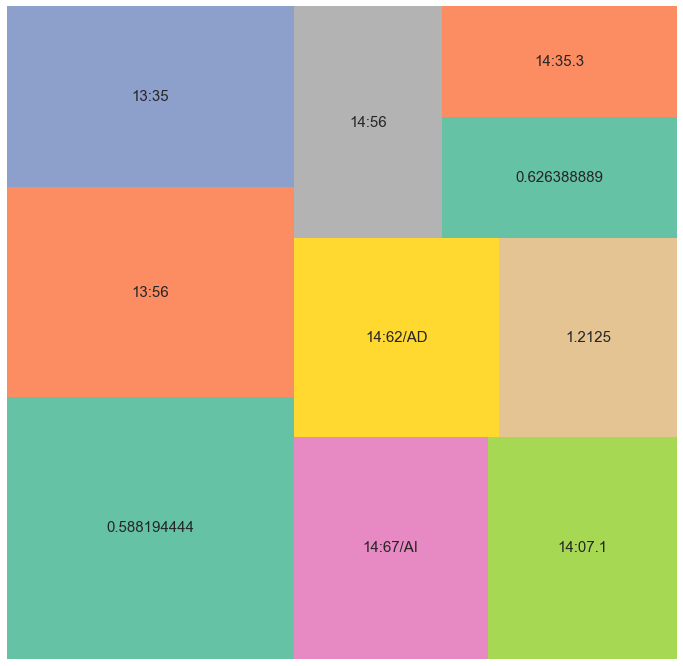

In [11]:
top_offense = df.groupby('OFFENSE')['OFFENSE'].agg('count').sort_values(ascending=False)[:10]

plt.figure(figsize=(12,12))
squarify.plot(sizes=top_offense.values,label=top_offense.index,
             color=sns.color_palette('Set2'),text_kwargs={'fontsize':15})
plt.axis('off')

#### Observation
* Section .588194444 was voilated highest number of times, followed by 13:56.

**NOTE**: While analysing different sections/articles which are under the laws of Unites States, some of the sections were not available on the internet, while some of them have documents that mention articles clearly.

#### 3. What  was the proportion of crime cases reported in each district (Complete District)?

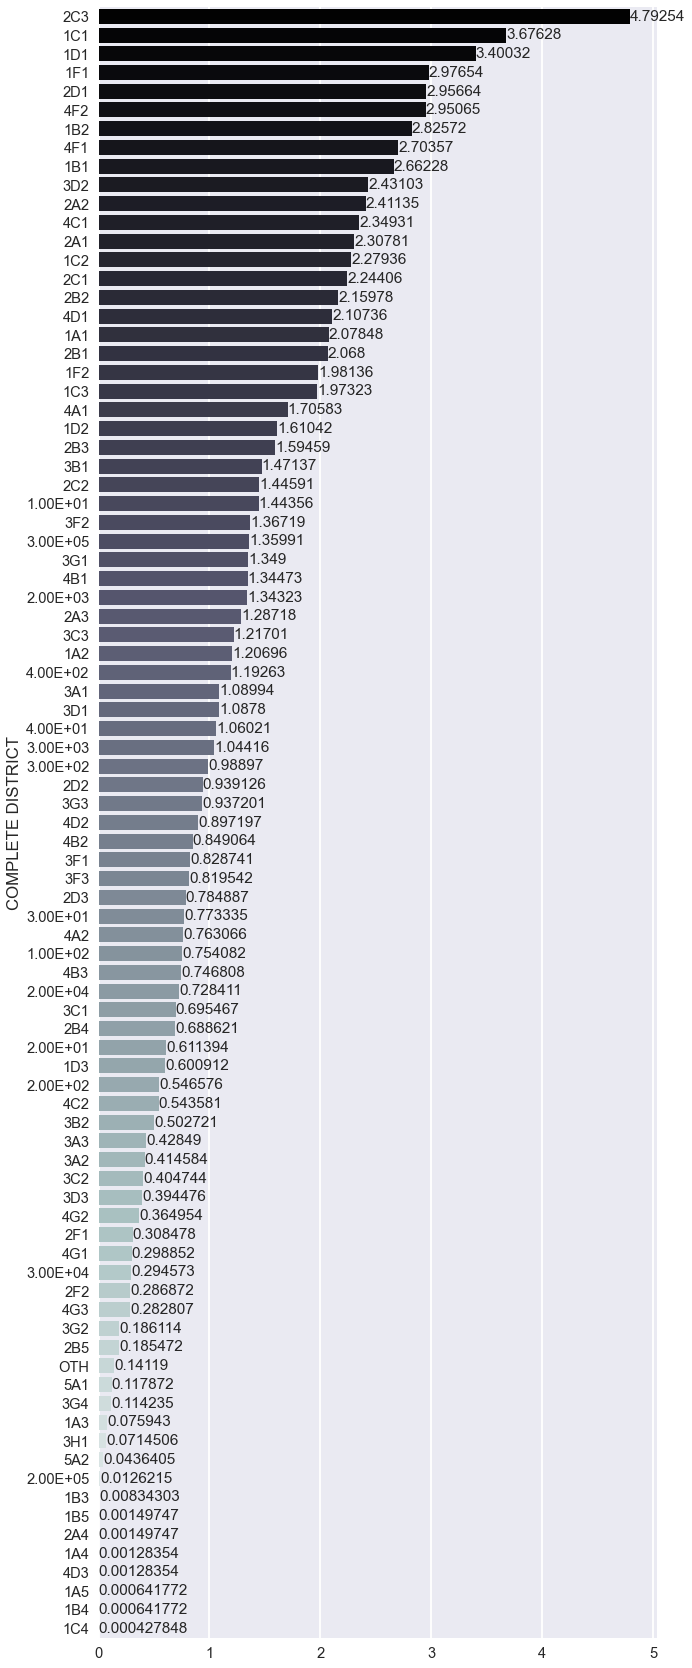

In [13]:
crime_byDist = df.groupby('COMPLETE DISTRICT')['COMPLETE DISTRICT'].agg('count').sort_values(ascending=False)
per_crime_byDist = (crime_byDist/crime_byDist.sum())*100

plt.figure(figsize=(10,30))
ax = sns.barplot(y=per_crime_byDist.index, x=per_crime_byDist.values, palette='bone')
for i in ax.containers:
    plt.bar_label(i)
plt.show()

#### Observation:
1. Around 4.8% of the crimes were registered in the 2C3 district of the Baton Rouge, it was the most voilent district of all the 89 districts.
2. District 1C4 seem to be the least voilent city.
3. We can also see that some of the ditricts are not in a proper format such as 1.00E+01, which means it was not formatted properly. So we may need to clean it, to present in a proper format.

#### 4. Let's analyse it more, and find some interesting insights.

First we try to find out quantile where the 50% of the data will be less and 50% of the data will be lower than it.

Why we are doing so?

Because this will help us to understand that what is number of districts from which 50% of the crimes were being registered.

Let's see practially, that what I mean.

In [2]:
# find the quantile
separater =  per_crime_byDist.quantile(.8)

# get crime districts which are greather than quantile
top_crime_dist = per_crime_byDist[per_crime_byDist>separater]

# let's see if this percentile value is correct 
print(top_crime_dist.sum()/per_crime_byDist.sum())

NameError: name 'per_crime_byDist' is not defined

In [15]:
# let's see how many districts are there in the first halve
print('50% of the crime cases were comming from {} districts, while the remaining 50% from the {} districts.'\
          .format(len(top_crime_dist),len(per_crime_byDist)-len(top_crime_dist)))

50% of the crime cases were comming from 18 districts, while the remaining 50% from the 69 districts.


#### Observtion:

* It is a very interesting finding, which shows us that only **18** cities contributes to **50%** of the crime in the city of Baton rouge. 
* This may help the Police and District Authorities to deploy more police units in these districts.
* And thats not only thing that would help in the reduction of the crimes in these districts, they may need to find the root cause of higher crime rate by interacting with the people of the districts, to understand that what is influencing the criminals to go violent. 
* It could be unemployment, lack of education, and some other factors.

#### 5. Average crime rate in both the halves of the districts.

In [16]:
print('Average crime rate in top 18 districts is {}%.'.format(round(np.average(top_crime_dist.values),3)))

# getting the remaining dists
remaing_dists = [i for i in per_crime_byDist.index if i not in top_crime_dist.index]
remaing_dists = per_crime_byDist.loc[remaing_dists]
print('Average crime rate in remaining 69 districts is {}%.'.format(round(np.average(remaing_dists.values),3)))

Average crime rate in top 18 districts is 2.74%.
Average crime rate in remaining 69 districts is 0.735%.


#### Observation:
* The average crime rate in the top 18 districts is extremly high when compared to the remainig 69 districts.

#### 6. Let's dig deeper and foucs on these 18 districts

Now, we will try to find out top street names from where which top cases are coming from.

In [17]:
dist_19 = df[(df['COMPLETE DISTRICT']=='2C3')|
             (df['COMPLETE DISTRICT']=='1C1')|
            (df['COMPLETE DISTRICT']=='1D1')|
            (df['COMPLETE DISTRICT']=='1F1')|
            (df['COMPLETE DISTRICT']=='2D1')|
            (df['COMPLETE DISTRICT']=='4F2')|
             (df['COMPLETE DISTRICT']=='1B2')|
             (df['COMPLETE DISTRICT']=='4F1')|
            (df['COMPLETE DISTRICT']=='1B1')|
            (df['COMPLETE DISTRICT']=='3D2')|
            (df['COMPLETE DISTRICT']=='2A2')|
            (df['COMPLETE DISTRICT']=='4C1')|
            (df['COMPLETE DISTRICT']=='2A1')|
            (df['COMPLETE DISTRICT']=='1C2')|
            (df['COMPLETE DISTRICT']=='2C1')|
            (df['COMPLETE DISTRICT']=='2B2')|
            (df['COMPLETE DISTRICT']=='4D1')|
            (df['COMPLETE DISTRICT']=='1A1')]

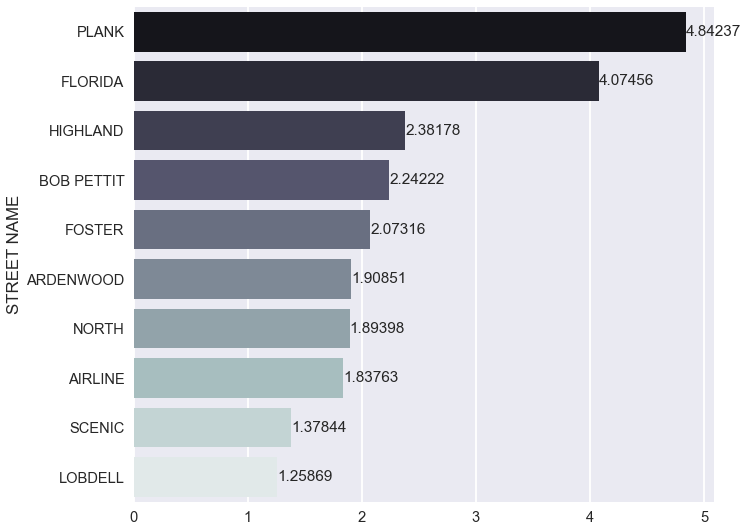

Total Number of Street Names 2499


In [18]:
crime_byStreet = dist_19.groupby('STREET NAME')['STREET NAME'].agg('count').sort_values(ascending=False)
per_crime_byStreet = (crime_byStreet/crime_byStreet.sum())*100
per_crime_byStreet = per_crime_byStreet[:10]

# barplot
ax = sns.barplot(x=per_crime_byStreet.values,y=per_crime_byStreet.index,palette='bone')
for i in ax.containers:
    plt.bar_label(i)
plt.show()
print('Total Number of Street Names',dist_19['STREET NAME'].nunique())

#### Observation:
* Plank and Florida street seem to be the most affected streets where most number of criminals activities took place.

#### 7. What is total proportion of crime in top 10 streets?

In [19]:
print('Percentage of Crimes cases in top 10 streets is {}% (cosidering the 18 districts only).'.format(round(per_crime_byStreet.sum(),3)))

Percentage of Crimes cases in top 10 streets is 23.891% (cosidering the 18 districts only).


#### 8. Compare top 10 streets crimes cases to the total number of crimes in the dataset and find out the percentage.

In [20]:
# Formula to implement the second part of the question is:
# sum of top 10 street Crimes/total number of crimes in the dataset
print('Proportion of Crimes in top 10 streets by the total number of crimes in the whole city is {}%.'.format(round((crime_byStreet[:10].sum()/len(df))*100,2)))

Proportion of Crimes in top 10 streets by the total number of crimes in the whole city is 11.06%.


#### Observation:
* Almost 11% of the crimes cases that were registered had these 10 streets in common, and this is quite a large proportion.

#### Let's get back to our complete set  of data now.
As we know that there is hierarcy present in the dataset, under different locaion columns. However, we cannot visualize it using python. So, I will try to represent in the from of graphs and figures.

#### 9. At what time of the day most of the crimes were commited/reported?

In [21]:
# In order to group the data by time on hourly basis, we are required to take only the hour of the day.
df['Hour'] = [i[:2] for i in df['Time']] 
df['Hour'].head(5)

0    16
1    22
2    05
3    23
4    16
Name: Hour, dtype: object

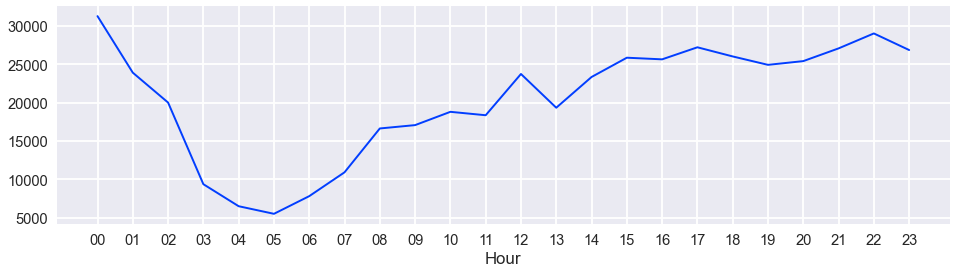

In [22]:
hour_g = df.groupby('Hour')['Hour'].agg('count').sort_index(ascending=True)
hour_g.drop(['0:','1]','7.','8.'],inplace=True)

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=hour_g.index,y=hour_g.values)
plt.show()

#### Observation
* Crime rates drop down sharply afer midnight, i.e. after 1 AM. Nonetheless, they start increasing after 5 AM in the morning.
* The time frame between 3 PM and 12 AM seem to be the most critical, where more than 25K crimes were committed at each hour (do not generalise it as 25K crimes per day).
* The most highest number of crimes were happend at 12AM, which constitutes more than 6% of the total crimes in the 10 years.

#### 10. What is total proportion of crimes committed between 3PM to 12AM to the total number of crimes in the dataset?

In [23]:
from3to12 = hour_g.loc[['15','16','17','18','19','20','21','22','23','00']].sum()
print('Percentage of Crimes between 3PM to 12AM is {}%'.format(round((from3to12/len(df))*100,3)))

Percentage of Crimes between 3PM to 12AM is 54.911%


#### Observation
* More than 54% of the crimes were committed between 3PM to 12AM, which is quite a large percentage. And shows a pattern that might help the City Authorities in reduction of the crime rate.

## 11. Get the total number of deaths on each day, week, month of the year.

#### 11.A. Number of crimes each day.

In [24]:
# First let's check the data type of the date column
df['date'].dtype

dtype('O')

In [25]:
# Above it can be seen that it is Object type, so we will convert it to datetime type
df['date'] = pd.to_datetime(df['date'])

In [26]:
df['date'].describe()

C:\Users\Sahil\AppData\Local\Temp\ipykernel_8100\801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                  490578
unique                   3657
top       2011-03-25 00:00:00
freq                      290
first     2011-01-01 00:00:00
last      2021-01-06 00:00:00
Name: date, dtype: object

As we know that we have around 10 year of data, and in total we have data of 3657 days. Now, I have an idea to group the data by day and add an another column which is the number of crimes on each day. After that we can use a time series to predict the future crime rate.

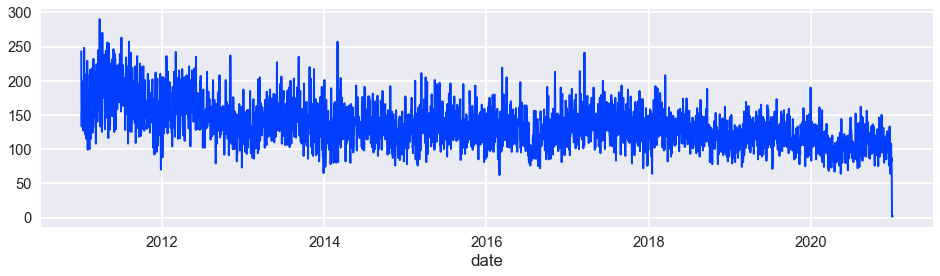

In [27]:
# First let's visualize the data using a line plot
day_group = df.groupby('date')['date'].agg('count')

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=day_group.index,y=day_group.values)
plt.show()

#### Observation
* As we could see it is hard to understand yet, so we will try to find the weekly and monthly pattern.
* Another thing to notice herer is that, the crime rate is felling suddenly at the end of 2020, the reason could be that the dataset may not have enough number of datapoints for Jan 2021. So let's see this, and if that is the case we will chop off those values from the year 2021.

In [28]:
len(df[df['date']>'2020-12-31'])

60

Our assumption was correct, there are only 60 datapoints after the December 2020, making the line to fell off quickly. So we'll remove it.

In [29]:
df = df[df['date']<='2020-12-31']

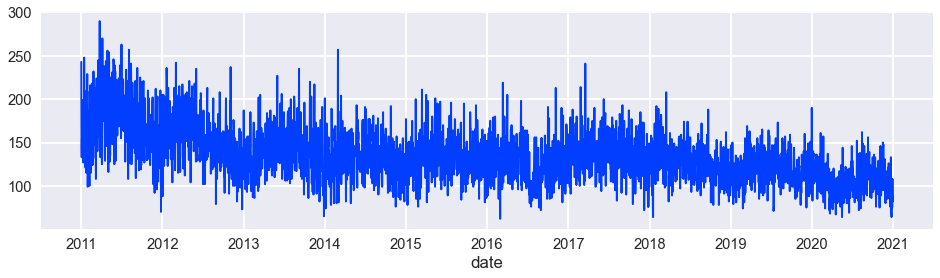

In [30]:
# let's plot it again
day_group = df.groupby('date')['date'].agg('count')

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=day_group.index,y=day_group.values)
plt.show()

#### 11.B. Number of crimes each week

*First, we group the data by week, for this we will use numpy array to group the data. Ideally we should get around 520 weeks*

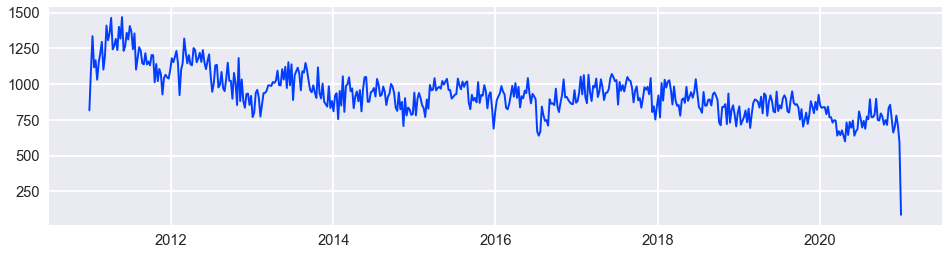

In [31]:
week_group = df.groupby(np.array(df['date'],dtype='datetime64[W]'))['date'].agg('count')

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=week_group.index,y=week_group.values)
plt.show()

#### Observation
* Overall the the number of crimes have been dreased greatly by approximately 55% in the during of 10 years.
* We can also observer a slight pattern in where the number of crimes committed spikes in the beginning of the year and after staying on the top for few months, it starts plunging down. Let's make it clear by grouping it monthly.

#### 11.C. Number of crimes each month

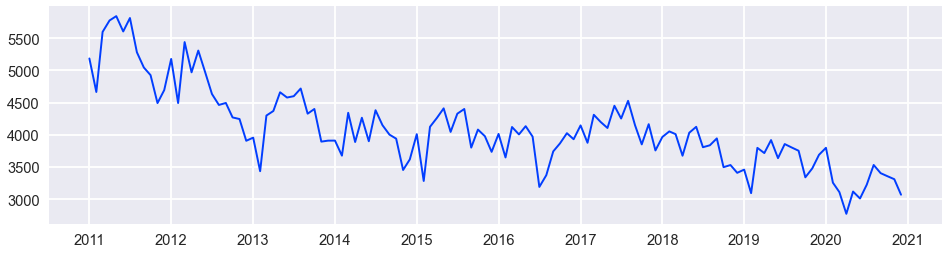

In [32]:
month_group = df.groupby(np.array(df['date'],dtype='datetime64[M]'))['date'].agg('count')

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=month_group.index,y=month_group.values)
plt.show()

#### Observation
* There is certainly a pattern, where the crime rate is increasing duiring the start of the year and decreasin in the end of the year.

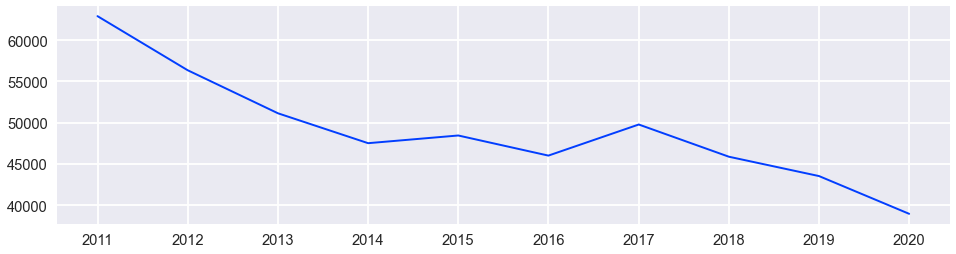

In [33]:
year_group = df.groupby(np.array(df['date'],dtype='datetime64[Y]'))['date'].agg('count')

plt.figure(figsize=(16,4))
fig = sns.lineplot(x=year_group.index,y=year_group.values)
plt.show()


#### Obervation
* No doubt that the number of crime getting committed had dcreased from around 62K in 2011 to around 38K in the year 2020.

### Aggregating data by date and making a new Dataframe

In [34]:
df_new = df.pivot_table(index=['date'],values=['COMMITTED'],aggfunc='count')
df_new.head()

,COMMITTED
date,
2011-01-01,243
2011-01-02,145
2011-01-03,133
2011-01-04,154
2011-01-05,142


### 12. Distribution of data 

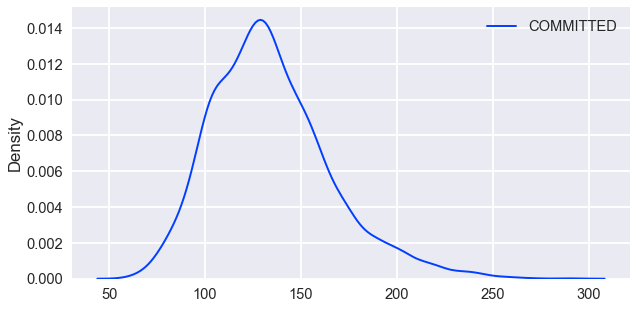

In [35]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_new)
plt.show()

Tee data is distributed normally, while there are some outliers present at the right tail of the distribution.

#### 13. Analysing the Trend, seasonality using statsmodel

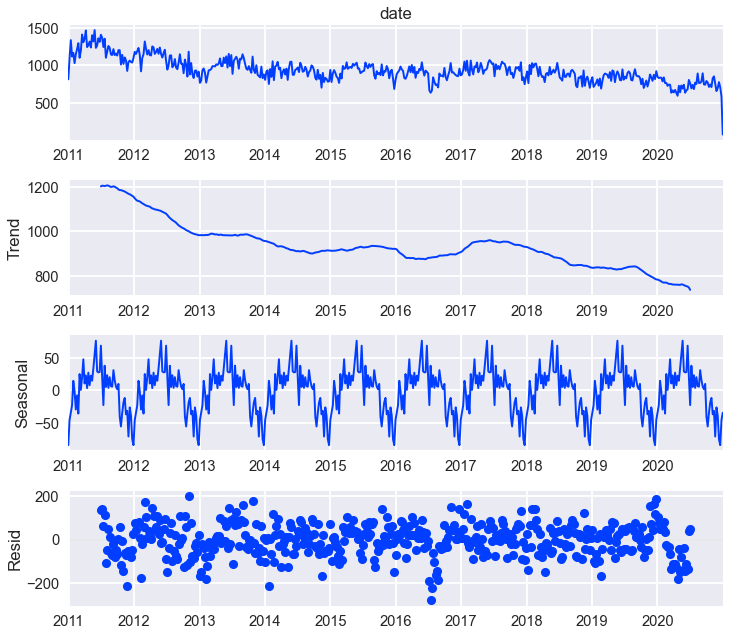

In [36]:

# we will use the weekly data to viualize it.
res = seasonal_decompose(week_group,model='additive')
res.plot()
plt.show()

#### Observation
* The trend is downward, as we saw that earlier also.
* The statistical model was also justigying our analysis of seasonal trend, where the crime rate is decreasing at the end of the year and increasing at the start of the month.

### XGBoost

We will use XGBoost regressor to predict the number of crimes for the future. And here I am treating it as a regression problem, where the feature will be the total weekly orders of previous month and total monthly orders of previous month, using which we will predict the next week's total number of crimes.

First, we combine the by week using the groupby(), the reason we are doing this is because we want to predict the number of crime in the next month, so our training set should also contain the weekly data.

In [37]:
week_group = df_new.groupby(np.array(df_new.index,dtype='datetime64[W]')).agg('sum').sort_index()
week_group.head()

,COMMITTED
2010-12-30,817
2011-01-06,1096
2011-01-13,1335
2011-01-20,1118
2011-01-27,1167


#### Features
* **prev_week_crimes**: The sum of the total number of crimes committed in the last week.
* **prev_month_crimes**: The sum of the total number of crimes committed in the last month.
* **target**: The sum of the total number of crimes committed in the next week.

###### In layman's term:
We are asking to our model that I have the data of crimes committed in the last week and the crimes committed in the last month, for this data please predict that what would be the total number of crimes in the next week.

In [38]:
a = week_group.copy()
a['target'] = a.shift(-1)                                  # our target is to predic the total number of crimes in the next week
a['prev_week_crimes'] = a['COMMITTED'].rolling(1).sum()    # total numbber of crimes in last week
a['prev_month_crimes'] = a['COMMITTED'].rolling(4).sum()   # total number of crimes in last month
a.head(10)

,COMMITTED,target,prev_week_crimes,prev_month_crimes
2010-12-30,817,1096.0,817.0,NaN
2011-01-06,1096,1335.0,1096.0,NaN
2011-01-13,1335,1118.0,1335.0,NaN
2011-01-20,1118,1167.0,1118.0,4366.0
2011-01-27,1167,1031.0,1167.0,4716.0
2011-02-03,1031,1149.0,1031.0,4651.0
2011-02-10,1149,1216.0,1149.0,4465.0
2011-02-17,1216,1295.0,1216.0,4563.0
2011-02-24,1295,1102.0,1295.0,4691.0
2011-03-03,1102,1193.0,1102.0,4762.0


In [39]:
# dropping null values
a.dropna(inplace=True)
a.isna().sum()

COMMITTED            0
target               0
prev_week_crimes     0
prev_month_crimes    0
dtype: int64

In [40]:
# splitting into train test set
features = ['prev_week_crimes','prev_month_crimes']
label = 'target'
train = a[a.index<'2020-06-17']
test = a[a.index>='2020-06-17']
x_tr, y_tr, x_ts, y_ts = train[features],train[label],test[features],test[label]


# training the model
model = XGBRegressor(learning_rate=1,n_jobs=10)
model.fit(x_tr,y_tr,
         eval_set=[(x_tr,y_tr),(x_ts,y_ts)],
         eval_metric='mae')

[0]	validation_0-mae:75.37097	validation_1-mae:91.05511
[1]	validation_0-mae:53.58047	validation_1-mae:80.03402
[2]	validation_0-mae:50.05007	validation_1-mae:79.40639
[3]	validation_0-mae:47.10582	validation_1-mae:79.32606
[4]	validation_0-mae:44.62251	validation_1-mae:81.32960
[5]	validation_0-mae:38.70724	validation_1-mae:80.50050
[6]	validation_0-mae:35.58894	validation_1-mae:80.06934
[7]	validation_0-mae:30.82383	validation_1-mae:80.13407
[8]	validation_0-mae:28.81021	validation_1-mae:83.37239
[9]	validation_0-mae:25.51319	validation_1-mae:83.25565
[10]	validation_0-mae:22.80687	validation_1-mae:84.57256
[11]	validation_0-mae:21.41127	validation_1-mae:86.59963
[12]	validation_0-mae:19.25196	validation_1-mae:85.26116
[13]	validation_0-mae:18.14237	validation_1-mae:85.57725
[14]	validation_0-mae:16.91468	validation_1-mae:85.57920
[15]	validation_0-mae:15.43452	validation_1-mae:86.23103
[16]	validation_0-mae:13.89022	validation_1-mae:86.34436
[17]	validation_0-mae:13.05472	validation

C:\Users\Sahil\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[35]	validation_0-mae:4.11395	validation_1-mae:88.12232
[36]	validation_0-mae:3.94624	validation_1-mae:88.12302
[37]	validation_0-mae:3.58894	validation_1-mae:88.23475
[38]	validation_0-mae:3.35816	validation_1-mae:88.83941
[39]	validation_0-mae:3.18376	validation_1-mae:88.84068
[40]	validation_0-mae:2.92502	validation_1-mae:88.85929
[41]	validation_0-mae:2.79996	validation_1-mae:89.42962
[42]	validation_0-mae:2.68092	validation_1-mae:89.24129
[43]	validation_0-mae:2.55684	validation_1-mae:89.24309
[44]	validation_0-mae:2.22073	validation_1-mae:89.23994
[45]	validation_0-mae:2.08388	validation_1-mae:89.31083
[46]	validation_0-mae:1.99588	validation_1-mae:89.30520
[47]	validation_0-mae:1.87903	validation_1-mae:89.30912
[48]	validation_0-mae:1.78875	validation_1-mae:89.30627
[49]	validation_0-mae:1.62446	validation_1-mae:89.30382
[50]	validation_0-mae:1.52844	validation_1-mae:89.18099
[51]	validation_0-mae:1.50608	validation_1-mae:89.18392
[52]	validation_0-mae:1.42110	validation_1-mae:8

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=6, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=10, num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [41]:
# making predictions
pred = model.predict(x_ts)
test['pred'] = np.round(pred)
(test['COMMITTED']-test['pred']).mean()

C:\Users\Sahil\AppData\Local\Temp\ipykernel_8100\2214149781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = np.round(pred)


-20.75

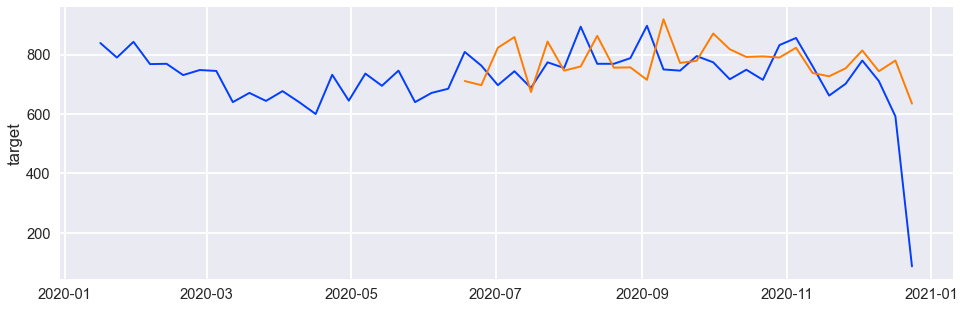

In [43]:
plt.figure(figsize=(16,5))
sns.lineplot(data=a.tail(50),x=a.tail(50).index,y='target')
sns.lineplot(data=test,x=test.index,y='pred')
plt.show()

#### Observation
* XGBoost is clearly doing a great job, where it is closely predicting the number of cases. However, there is still a room for improvement in this model, where we can optimize the hyperparameters using GridsearchCV(), and further improve the performance of the model.

### Model Assessment

In [54]:
def performance_metrics(y_tr,y_pred):
    print('MAE: {}'.format(round(mean_absolute_error(y_tr, y_pred),2)))
    print('MSE:{}'.format(round(np.sqrt(mean_squared_error(y_tr, y_pred)), 2)))
    print('MAPE:{}'.format(round(np.sqrt(mean_absolute_percentage_error(y_tr, y_pred)), 2)))

In [55]:
performance_metrics(test['COMMITTED'],test['pred'])

MAE: 59.04
MSE:72.42
MAPE:0.28


| **Investigation Question** 	| **Findings** 	|
|---	|---	|
| 1. What is the total number of records in the dataset?  	| There are approximately 490578 crimes in the dataset.   	|
| 2. What is the proportion of missing values in the dataset? 	| The dataset has around 4.8% of the missing data. 	|
| 3. What are the causes of crimes? 	| There are 17 causes of crime in the city of Baton Rogue. 	|
| 4. What are the top-committed crimes? 	| Theft and Battery were committed the highest number of times. 	|
| 5. Which article/section of law was violated the highest number of times? 	| Article number 13:56 and 13:35 is at the top of the list of violation. 	|
| 6. Which district(complete district) reported the highest number of crimes? 	| District 2C3 had the highest crime rate, which is 4.79%. 	|
| 7. How many districts are in the dataset, and what is the number of districts that constitute the 50% of the total cases? 	| There are total 87 Districts (complete districts), out of which 18 districts holds the 50% of the total crime. 	|
| 8. What the average crime rate in top 18 district compared to the remaining districts? 	| Average crime rate in the top 18 districts is 2.74%, while 0.73% in the remaining districts. 	|
| 9. In top 18 districts, what were the most violent streets? 	| Plank was the most violent street, followed by the Florida street. 	|
| 10. What proportion of crimes do the top 10 streets hold in the 18 districts? 	| Out of 2500 streets, the top 10 streets hold 23% of the total crime in the 18 districts, which is around 11% of the total crimes in the dataset. 	|
| 11. At what time of the day, most of the crimes were committed? 	| The highest number of crimes were committed between 3PM to 12AM, which is 54% of the total crimes. 	|
| 12. How do the trend looks like for this data, and what are the key observations? 	| a. The number of crime rate had decreased over the period of 10 years by approximately 55%.<br>b. The number of crimes spikes in the beginning of the year and start declining after the mid of the year. 	|